# framework RACC


## imports

In [4]:
# reloading 
%load_ext autoreload
%autoreload 2

# importing librairies
from matplotlib.font_manager import json_load
import json
import glob
import numpy as np
import datetime
from datetime import datetime
import sys

# importing RACC modules
from segmentation import classification

# importing modules from Images
sys.path.insert(0, r'../Images')
from Image import Image
from File import File
from Geotiff_Format import Geotiff_Format

# importing meteosat API modules
sys.path.insert(0, r'API_meteosat')
from eds_get_nearest import search_nearest,download_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dates et projection

In [5]:
main_dir = r"../../data/RACC/decembre"
path_dates = r"../../data/RACC/decembre/acq_dates.json"

projection_path = r"param_guy.json"
projection = json.load(open(projection_path, "r", encoding="utf-8"))

target_dates = [
    "2021-11-30 10:11:07",
    "2021-12-01 20:00:54",
    "2021-12-03 22:17:15",
    "2021-12-04 22:03:37",
    "2021-12-12 21:57:28",
    "2021-12-13 21:44:29",
    "2021-12-22 20:24:51",
    "2021-12-25 21:50:50"
]

format = "%Y-%m-%dT%H:%M:%S.%f%z"

In [6]:
def get_dates(path_dates):
    with open(path_dates, "r", encoding="utf-8") as json_dict:
        dates = json.load(json_dict)
    return dates
    
def save_dates(dates,path_dates):
    with open(path_dates, 'w', encoding="utf-8") as json_dict:
        json.dump(dates, json_dict, indent=4, default=str)
        
dates = {d.split(" ")[0]:{
        "target":d,
        "SSMIS":"",
        "date_acq_SSMIS":"",
        "Meteosat":"",
        "date_acq_Meteosat":"",
        "Ir":""
        } for d in target_dates}
dates = {d.split(" ")[0]:{"target":d} for d in target_dates}
#save_dates(dates,path_dates)

## Extraction des images SSMIS 

In [9]:
def search_near_SSMI(dir,projection,tg_date,freq="*",pola="*"):
    year = str(tg_date.year)
    days = (tg_date - datetime.strptime(year,"%Y")).days
    delta_min, fn_min = np.iinfo(np.int32).max, None
    for offset in [-1,0,1]:
        fns = glob.glob(dir+ rf"/*/*{year}{days+offset}-{freq}{pola}-*.nc")
        for fn in fns:
            file = File(fn)
            acq_date = file.getTime(projection,"TB_time").replace(tzinfo=None)
            img = file.project(r"../../data/test.tiff",projection,"TB")
            delta = (tg_date-acq_date).total_seconds()
            try :
                unique, counts = np.unique(img.array, return_counts=True)
                zero_rate = dict(zip(unique, counts))[0]/(img.array.shape[0]*img.array.shape[1])
            except KeyError:
                zero_rate = 0
            if (zero_rate < 0.1) and (np.abs(delta) < delta_min):
                delta_min, fn_min = delta, fn
    file = File(fn_min)
    return file, file.getTime(projection,"TB_time")

def select_and_project_SSMIS_images(dir,out_dir,path_dates,projection,freq=91,polar="*"):
    """
    sélectionne parmis les données SSMIS téléchargées les plus proches des dates retenues
    permet de convertir ces fichiers puis de les géoréférencer à partir du dictionnaire projection
    """
    dates = get_dates(path_dates)
    for d in dates.keys():
        dt = datetime.strptime(dates[d]["target"], "%Y-%m-%d %H:%M:%S")
        file,acq = search_near_SSMI(dir,projection,dt,freq,polar)
        filename = out_dir + rf"/SSMIS_{d}.tiff"
        file.project(filename,projection,"TB")
        dates[d]["SSMIS"] = filename
        dates[d]["acq_SSMIS"] = acq.strftime(format)
    save_dates(dates,path_dates)

In [10]:
SSMIS_src_dir = r"../../data/SSMI/download_dec_2021"

select_and_project_SSMIS_images(SSMIS_src_dir,main_dir,path_dates,projection)

## Extraction des images Meteosat

In [122]:
def download_Meteosat_images(path_dates,path_unzipped,path_download,path_keys):
    dates = get_dates(path_dates)
    
    prod_list = []
    for d in dates.keys():
        prod, end_acq_date = search_nearest(datetime.strptime(dates[d]["acq_SSMIS"],format))
        dates[d]["Meteosat"] = fr"{path_unzipped}/{prod}.nat"
        dates[d]["acq_Meteosat"] = datetime.strftime(end_acq_date,format)
        prod_list.append(prod)
    
    #download_dataset(prod_list,path_download,path_unzipped,path_keys)
    save_dates(dates,path_dates)

def project_Meteosat_images(path_dates, main_dir, projection, attribute):
    dates = get_dates(path_dates)
    for d in dates.keys():
        filename = main_dir + rf"/{attribute}_{d}_proj.tiff"
        meteosat_file = File(dates[d]["Meteosat"])
        meteosat_file.project(filename,projection,attribute)
        dates[d][f"{attribute}"] = filename
    save_dates(dates,path_dates)
        

In [ ]:
path_download=r"../../data/IR"
path_keys = r"../../data/keys/eds.key"

#download_Meteosat_images(path_dates,main_dir,path_download,path_keys)
project_Meteosat_images(path_dates, main_dir, projection, "IR_087")

## Agrégation des données

In [11]:
def agregation(path_dates,out_dir,key,mode="mean",compute_var=False):
    arrays = []
    dates = get_dates(path_dates)
    for d in dates.keys(): # récupération des images
        file = File(dates[d][key])
        if file.format != Geotiff_Format:
            print("le fichier doit être en format Geotiff")
            raise
        img = file.getImage(1)
        arrays.append(img.array)
    
    lons,lats = img.lons, img.lats
    if mode == "mean":
        output = np.mean(np.array(arrays),axis=0)
    else:
        output = np.sum(np.array(arrays),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_dir + rf"/{key}_agreg.tiff")
    if compute_var:
        img_output_var = img_output.computeVar()
        img_output_var.save(projection,out_dir + rf"/{key}_agreg_var.tiff")
        


In [12]:
seg_dir = main_dir + r"/segmentation"
#key = "IR_087" ; var = True
key = "SSMIS" ; var = False
agregation(path_dates,seg_dir,key,compute_var=var)

c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


## Classification

Segmentation des images en entrée à partir de la méthode des K-means

c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


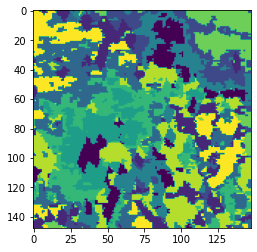

In [13]:
array_pred,centers = classification(seg_dir,projection,N=10,epsilon=0.001,T=100)

## no man's land

o

o

o

o

o

o

o


In [ ]:

"""
from osgeo import gdal
a = r"../../data/SSMI/download_dec_2021\238356902\NSIDC-0630-EASE2_N25km-F18_SSMIS-2021333-91V-E-GRD-CSU_ICDR-v1.5.nc"
ds = gdal.Open("NETCDF:{0}:{1}".format(a, "TB_time"))
print(ds.GetGeoTransform())
"""

# ex code
def selection_dir(dir,projection,attribute,zero_rate=0.1):
    paths = glob.glob(dir + "*/*.nc")
    out_dict = {}
    for path in paths:
        file = File(path)
        image = file.project("temporary.tiff",projection,attribute)
        arr = image.array
        try :
            unique, counts = np.unique(arr, return_counts=True)
            zero_rate = dict(zip(unique, counts))[0]/(arr.shape[0]*arr.shape[1])
        except KeyError:
            zero_rate = 0
        if zero_rate < 0.1:
            date = file.getTime(projection,f"{attribute}_time")
            date = date.strftime("%Y-%m-%d %H:%M:%S")
            out_dict[date] = path
    with open(dir+"dates.json", 'w', encoding='utf-8') as f:
        json.dump(out_dict, f, ensure_ascii=False, indent=4)
    return out_dict

def download_IR(filenames,projection,attribute):
    for fn in filenames:
        file = File(fn)
        date = fn.split("-")[-2]
        yyyy,mm,dd = date[:4],date[4:6],date[6:8]
        file.project(rf"../data/IR/agregation/{attribute}_{yyyy}-{mm}-{dd}.tiff",projection,attribute)
    """
    file = File(fn)
    download_all(file,r"../data/IR/results/IR{")
    """

def aggregation(projection,out_name,images=[],dir=False,mode="mean"):
    if dir:
        images = []
        filenames = glob.glob(rf"{dir}*.tiff")
        for fn in filenames:
            file = File(fn)
            images.append(file.getImage(1).array)
            lons,lats = file.getImage(1).lons, file.getImage(1).lats
    if mode == "mean":
        output = np.mean(np.array(images),axis=0)
    else:
        output = np.sum(np.array(images),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_name)
    
def search_near_SSMI(dir,projection,tg_date="*",freq="*",pola="*"):
    year = str(tg_date.year)
    days = (tg_date - datetime.strptime(year,"%Y")).days
    delta_min, fn_min = np.iinfo(np.int32).max, None
    for offset in [-1,0,1]:
        fns = glob.glob(dir+ rf"/*/*{year}{days+offset}-{freq}{pola}-*.nc")
        for fn in fns:
            file = File(fn)
            acq_date = file.getTime(projection,"TB_time").replace(tzinfo=None)
            img = file.project(r"../data/test.tiff",projection,"TB")
            delta = (tg_date-acq_date).total_seconds()
            try :
                unique, counts = np.unique(img.array, return_counts=True)
                zero_rate = dict(zip(unique, counts))[0]/(img.array.shape[0]*img.array.shape[1])
            except KeyError:
                zero_rate = 0
            if (zero_rate < 0.1) and (np.abs(delta) < delta_min):
                delta_min, fn_min = delta, fn
    file = File(fn_min)
    return file, file.getTime(projection,"TB_time")

def prepare_data_RACC(main_dir,dates,projection):
    """
    sélectionne parmis les données SSMIS et IR les fichiers d'intérêt 
    télécharge ces fichiers puis les géoréférence de la même manière
    aggrège les données et calcule la variance des images IR
    """
    SSMI_imgs = []
    for date in dates:
        dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S") ; freq = 91 ; pola = "*"
        file,acq = search_near_SSMI("../data/SSMI/download_dec_2021",projection,dt,freq,pola)
        date_str = acq.strftime("%Y-%m-%d")
        img = file.project(rf"../data/RACC/produced/SSMIS_{date_str}.tiff",projection,"TB")
        SSMI_imgs.append(img.array)
    aggregation(projection,rf"../data/RACC/produced/SSMIS_agrege.tiff",SSMI_imgs)



    prepare_data_RACC(dir,dates,projection)
    

    #download_IR(glob.glob(r"../data/IR/*.nat"),projection,"IR_087")

    #aggregation(r"../data/SSMI/agregation/",projection,"mean")
    #aggregation(r"../data/IR/agregation/",projection,"mean",True)

    """
    
    dates_dir = json.load(open(r"../data/SSMI/dates.json", "r", encoding="utf-8"))
    
    for d in dates:
        filename = dates_dir[d].split("-")
        filename[-5] = "19V"
        f = '-'.join(filename)
        print(f)
    #download_SSMI_from_json(f"{dir}dates.json",dates,projection)
    """

"""
    #attributes = ['HRV', 'IR_016', 'IR_039', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134', 'VIS006', 'VIS008', 'WV_062', 'WV_073'] 
    attributes = ['IR_087']
    for att in attributes:
        out_path = rf"../data/test_seg/Meteosat_{att}.tiff"
        compute_var_path = rf"../data/test_seg/Meteosat_{att}_var.tiff"
        values = convert_nat(nat_path,out_path,proj_path,att,compute_var_path)

         for date in dates_dir.keys():
        dates_list.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
    dates = matplotlib.dates.date2num(dates_list)
    y = [1 for i in range(len(dates_list))]
    plt.plot_date(dates,y)
    plt.show()

    
    dates_list = list(dates_dir.keys())
    dates_list.sort()
    print(dates_list)
    """

